In [1]:
!pip install torchio

In [2]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


jason file 에서 fold 값에 따라
- tce 만사용
- 0 = val , 0! = train
- val df, train df 로 저장

In [ ]:
import json
import os
import pandas as pd
import torch
import random
import numpy as np
import torchio as tio
from torch.utils.data import Dataset, DataLoader

# 1. JSON 파일 경로
json_file_path = '/home/alpaco/msk/BraTS2021_Data/brats21_folds.json'

# 2. JSON 파일 읽기
with open(json_file_path, 'r') as f:
    folds_data = json.load(f)

# 3. t2 이미지와 seg 라벨만 포함한 DataFrame 생성 함수
def generate_train_df_from_folds(folds_data):
    data_train = []
    data_val = []
    
    for entry in folds_data['training']:
        fold = entry['fold']
        image_paths = entry['image']
        label_path = entry['label']
        
       # t1만 뽑기
        # "TrainingData/" 부분을 제거하고 절대 경로로 결합
        # /home/alpaco/msk/BraTS2021_Data/BraTS2021_00000/BraTS2021_00000_t1.nii.gz
        flair_image = os.path.join('/home/alpaco/msk/BraTS2021_Data', image_paths[3].replace('TrainingData/', ''))  # "TrainingData/" 제거
        label_image = os.path.join('/home/alpaco/msk/BraTS2021_Data', label_path.replace('TrainingData/', ''))  # "TrainingData/" 제거
        
        # 파일 존재 여부 확인
        if os.path.exists(flair_image) and os.path.exists(label_image):
            data_entry = {
                'image': flair_image,  # 'image' 컬럼에 t1 이미지 경로 추가
                'label': label_image,  # 'label' 컬럼에 라벨 경로 추가
                'fold': fold
            }
            
            if fold == 0:
                data_val.append(data_entry)
            else:
                data_train.append(data_entry)
        else:
            print(f"Skipping entry, file(s) not found: {flair_image}, {label_image}")
    
    # DataFrame으로 변환 후, fold 값 기준으로 정렬
    train_flair_df = pd.DataFrame(data_train).sort_values(by='image')
    val_flair_df = pd.DataFrame(data_val).sort_values(by='image')
    
    # DataFrame 확인
    print("Train DataFrame:")
    print(train_flair_df.head())
    
    print("Validation DataFrame:")
    print(val_flair_df.head())

    return train_flair_df, val_flair_df

# 4. DataFrame 생성
train_flair_df, val_flair_df = generate_train_df_from_folds(folds_data)

# 생성된 DataFrame 확인
print("Train DataFrame:")
print(train_flair_df.head())

print("Validation DataFrame:")
print(val_flair_df.head())

# CSV로 저장 (선택 사항)
train_flair_df.to_csv('/home/alpaco/msk/Unet3D_2021_t2/Unet3D_2021_train_t2.csv', index=False)
val_flair_df.to_csv('/home/alpaco/msk/Unet3D_2021_t2/Unet3D_2021_val_t2.csv', index=False)


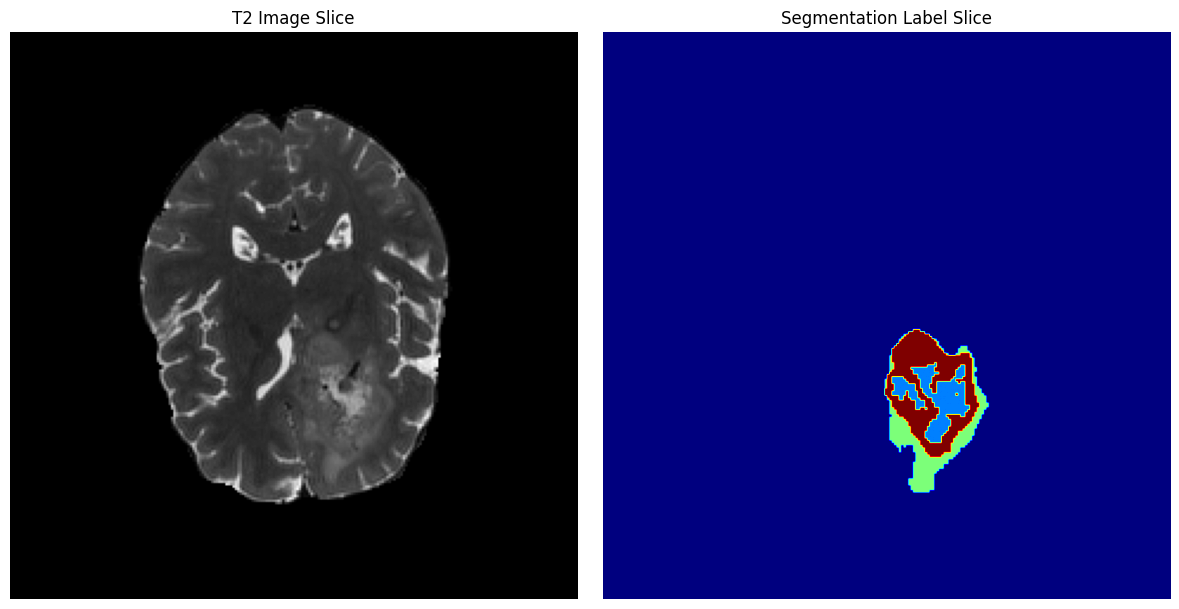

In [4]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# 이미지 파일 경로
image_path = '/home/alpaco/msk/BraTS2021_Data/BraTS2021_00000/BraTS2021_00000_t2.nii.gz'
label_path = '/home/alpaco/msk/BraTS2021_Data/BraTS2021_00000/BraTS2021_00000_seg.nii.gz'
# /home/alpaco/msk/BraTS2021_Data/BraTS2021_00005/BraTS2021_00005_t1.nii.gz

# NIfTI 이미지 로드
image_nii = nib.load(image_path)
label_nii = nib.load(label_path)

# 이미지 데이터를 numpy 배열로 변환
image_data = image_nii.get_fdata()
label_data = label_nii.get_fdata()

# 이미지는 3D이므로, 임의의 슬라이스를 선택해서 시각화
slice_idx = image_data.shape[2] // 2  # 이미지의 중간 슬라이스 선택

# 이미지 슬라이스와 라벨 슬라이스 추출
image_slice = image_data[:, :, slice_idx]
label_slice = label_data[:, :, slice_idx]

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# T1 이미지 시각화
axes[0].imshow(image_slice.T, cmap='gray', origin='lower')
axes[0].set_title('T2 Image Slice')
axes[0].axis('off')

# 세그먼트 라벨 시각화
axes[1].imshow(label_slice.T, cmap='jet', origin='lower')
axes[1].set_title('Segmentation Label Slice')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
train_df=pd.read_csv('/home/alpaco/msk/Unet3D_2021_t2/Unet3D_2021_train_t2.csv')
val_df = pd.read_csv('/home/alpaco/msk/Unet3D_2021_t2/Unet3D_2021_val_t2.csv')
train_df.head(3)
val_df.head(3)

,image,label,fold
0,/home/alpaco/msk/BraTS2021_Data/BraTS2021_0000...,/home/alpaco/msk/BraTS2021_Data/BraTS2021_0000...,0
1,/home/alpaco/msk/BraTS2021_Data/BraTS2021_0000...,/home/alpaco/msk/BraTS2021_Data/BraTS2021_0000...,0
2,/home/alpaco/msk/BraTS2021_Data/BraTS2021_0000...,/home/alpaco/msk/BraTS2021_Data/BraTS2021_0000...,0


transforom
- train = argument
- train ! =  고대로

In [6]:
# List transform
def get_transform(phase):
    if phase == 'train':
        list_transforms = [
            tio.RandomAffine(p = 0.5),
            tio.RandomFlip(axes=['LR', 'AP', 'IS'], p = 0.5),
#             tio.RandomBiasField(p = 0.25), MRI이미지의 강도 편향을 시뮬레이션
#             tio.RandomBlur(p = 0.25), 이미지의 블러 효과를 25% 확률로 적용
#             tio.RandomNoise(p = 0.25),랜덤 노이즈를 추가해 노이즈 저항성 높임
            
        ]
        # Transforms can be composed as in torchvision.transforms
        transform = tio.Compose(list_transforms)
    else: #검증 데이터에는 증강단계를 수행하지 않음으로써 평가의 일관성을 유지
        list_transforms = []
        transform = tio.Compose(list_transforms)
    return transform

#LR은 좌우 축(Sagittal) AP는 앞뒤 축 (Coronal) IS는 위아래 축(Axial)

bratsdataset
- data_img shape (1, 120, 120, 78)
- 라벨값 다 1로 

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
class BratsDataSet(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str = 'test'):
        self.df = df
        self.phase = phase #phase는 test, train, validation 중 하나
    def __len__(self):
        return self.df.shape[0] #전체 데이터 수 반환
    def __getitem__(self, index):
        # id_ = self.df.loc[index, 'image']
        # data_path = self.df.loc['img'].values[0]
        image_path = self.df.loc[index, 'image']
        label_path = self.df.loc[index, 'label']
        resample = tio.Resample((2,2,1.5)) #해상도 조정
        img = tio.ScalarImage(image_path) # data_img shape (1, 240, 240, 155)
        img = resample(img) # data_img shape (1, 120, 120, 78)
        img = np.array(img)
        img = np.squeeze(img, axis = 0) #첫번째 채널 축을 제거
        img = self.Normalize(img) #0과 1 사이 값으로 정규화
        img_stack = np.moveaxis(img, (0,1,2), (0,2,1))
        img_stack = torch.Tensor(img_stack)
        img_stack = torch.unsqueeze(img_stack, dim = 0)
        
        if self.phase != 'test': #phase가 test가 아니라면 (학습 또는 검증이라면)
            # data_path = self.df.loc[self.df['Brats20ID'] == id_]['Path'].values[0]
            labels = tio.LabelMap(label_path)
            labels = resample(labels)
            labels = np.array(labels)
            labels = np.squeeze(labels, axis = 0)
            label_stack = self.ConvertToMultiChannel(labels) #멀티라벨채널로 전환
            label_stack = torch.Tensor(label_stack)
            label_stack = torch.unsqueeze(label_stack, dim = 0)
            subjects = tio.Subject(image = tio.ScalarImage(tensor = img_stack),
                                   label = tio.LabelMap(tensor = (label_stack > 0.5)),
                                  )
            return subjects
        subjects = tio.Subject(image = tio.ScalarImage(tensor = img_stack))
        return subjects
    
    def Normalize(self, image : np.ndarray):
        return (image - np.min(image))/(np.max(image) - np.min(image))
 
    def ConvertToMultiChannel(self, labels):
        '''
        Convert labels to multi channels based on brats classes:
        label 1 is the peritumoral edema
        label 2 is the GD-enhancing tumor
        label 3 is the necrotic and non-enhancing tumor core
        The possible classes are TC (Tumor core), WT (Whole tumor)
        and ET (Enhancing tumor)
        '''
        label_WT = labels.copy()
        label_WT[label_WT == 1] = 1
        label_WT[label_WT == 2] = 1
        label_WT[label_WT == 4] = 1
        label_stack = np.moveaxis(label_WT, (0,1,2), (0,2,1))
        return label_stack
    
    #전체 종양 부위 (Whole Tumor ; WT) 만을 예측하려는 의도로 label_WT를 모두 1로 통일
    #멀티라벨세그멘테이션에서 이진분할로 전환 (종양이 있는지 없는지만 예측이 가능하게)
    #softmax 함수가 아닌 sigmoid 함수를 사용하여 정규화시켜야한다.

dataloader

In [8]:
import time
import torchio as tio
def get_dataloader(dataset, phase, batch_size = 1, num_workers = 4):

    start_time = time.time()
    # data = pd.read_csv(path_to_csv)
    train_data = pd.read_csv('/home/alpaco/msk/Unet3D_2021_t2/Unet3D_2021_train_t2.csv').reset_index(drop = True)
    val_data = pd.read_csv('/home/alpaco/msk/Unet3D_2021_t2/Unet3D_2021_val_t2.csv').reset_index(drop = True)
    #Fold 값이 현재 fold와 다른 데이터를 train_data로 하여 훈련 데이터 설정
    # val_data = data.loc[data['fold'] == 0].reset_index(drop = True)
    #Fold 값이 현재 fold와 같은 데이터를 val_data로 하여 검증 데이터 설정
    if phase == 'train':
        data = train_data
    else:
        data = val_data
    data_set = dataset(data, phase)
    list_subjects = []
    for i in range(len(data_set)):
        list_subjects.append(data_set[i])
    subject_dataset = tio.SubjectsDataset(list_subjects, transform=get_transform(phase))
    patch_size = 100 #240X240X155 이미지에서 100X100X100 만큼 떼어서 보겠다
    queue_length = 300 #queue_length에 저장할 패치의 최대 개수 (모델)
    sample_per_volume = 1 #환자 1명에게서 추출할 패치의 수
    sampler = tio.data.UniformSampler(patch_size)
    patches_queue = tio.Queue(
        subject_dataset,
        queue_length,
        sample_per_volume,
        sampler,
        num_workers=num_workers,
    )
    data_loader = DataLoader(patches_queue,
                             batch_size = batch_size,
                             num_workers=0,
                             pin_memory=True,
                            )
    return data_loader

#fold는 교차검증 시 필요한 인덱스로 n-fold의 경우 데이터셋을 n개로 나눈다
#n=5일때 fold = 0 (0이 val_data, 1 2 3 4가 train_data)
#n=5일때 fold = 1. (1이 val_data, 0 2 3 4가 train_data)
#패치(patch)는 이미지나 볼륨 데이터에서 작은 영역을 의미
#(240,240,155) -> (100,100,100) by patch

In [9]:
dataloader = get_dataloader(dataset=BratsDataSet, phase='train')
len(dataloader)

1000

diceloss

In [10]:
import torch.nn.functional as F
class DiceLoss(nn.Module):
    def __init__(self, weight = None, size_average = True):
        super(DiceLoss, self).__init__()
    def forward(self, inputs, targets, smooth = 1):
        # Commnent out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)
        
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs*targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum()+ targets.sum() + smooth)
        return 1 - dice

In [11]:
def dice_coef_metric(inputs: torch.Tensor, target: torch.Tensor, threshold: float = 0.5, eps:float = 1e-9) -> np.ndarray:
    """
    Calculate Dice score for data batch,
    Params:
        inputs: model outputs after activation function
        target: true values
        threshold: threshold for inputs
        eps: additive to refine the estimate
    Return: dice score 
    """
    score = []
    num = inputs.shape[0]
    predictions = (inputs >= threshold).float()
    assert(predictions.shape == target.shape)
    for i in range(num):
        predict = predictions[i]
        target_ = target[i]
        intersection = 2.0*(target_*predict).sum()
        union = target_.sum() + predict.sum()
        if target_.sum() == 0 and predict.sum() == 0:
            score.append(1.0)
        else:
            score.append((intersection + eps)/union)
    return np.mean(score)

# **BCE-Dice Loss**

In [12]:
class BCEDiceLoss(nn.Module):
    def __init__(self, weight = None, size_average = True):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    def forward(self, inputs, targets, smooth = 1):
        assert(inputs.shape == targets.shape)
        dice_loss = self.dice(inputs, targets)
        bce_loss = self.bce(inputs, targets)
        return  dice_loss + bce_loss
    

In [13]:
class Scores:
    def __init__(self, threshold: float=0.5):
        self.threshold = threshold
        self.dice_scores: list = []
    def update(self, logits: torch.Tensor, target: torch.Tensor):
        inputs = torch.sigmoid(logits)
        dice = dice_coef_metric(inputs, target, self.threshold)
        
        self.dice_scores.append(dice)
    def get_metrics(self):
        dice = np.mean(self.dice_scores)
        return dice

In [14]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        x = self.double_conv(x)
        return x

In [15]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        x = self.encoder(x)
        return x

In [16]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Make sure size data when you combine are the same size
        diffX = x2.size()[4] - x1.size()[4]
        diffY = x2.size()[3] - x1.size()[3]
        diffZ = x2.size()[2] - x1.size()[2]
        
        x1 = torch.nn.functional.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2))
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [17]:
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.out_conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.out_conv(x)

In [18]:
'''
                            UNET 3D
        1|->|->|---------------------------->|->|->|1

              2|->|->|---------------->|->|->|2

                    3|->|->|---->|->|->|3     

                          4|->|->|4
'''
class UNET3D(nn.Module):
    def __init__(self, in_channels, out_channels, n_classes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_classes = n_classes
        
        self.double_conv = DoubleConv(self.in_channels, self.out_channels)
        # encoder downsamplers
        self.down_1 = Down(self.out_channels, self.out_channels*2)
        self.down_2 = Down(self.out_channels*2, self.out_channels*4)
        self.down_3 = Down(self.out_channels*4, self.out_channels*8)
        self.down_4 = Down(self.out_channels*8, self.out_channels*16)

        # decoder upsamplers
        self.up_4 = Up(self.out_channels*16, self.out_channels*8)
        self.up_3 = Up(self.out_channels*8, self.out_channels*4)
        self.up_2 = Up(self.out_channels*4, self.out_channels*2)
        self.up_1 = Up(self.out_channels*2, self.out_channels)

        # output
        self.out = Out(self.out_channels, self.n_classes)
        
        self.dropout = nn.Dropout3d(0.5)
    def forward(self, x):
        # Encoder
        en_1 = self.double_conv(x)
#         en_1 = self.dropout(en_1)
        en_2 = self.down_1(en_1)
        en_2 = self.dropout(en_2)
        en_3 = self.down_2(en_2)
#         en_3 = self.dropout(en_3)
        en_4 = self.down_3(en_3)
        en_4 = self.dropout(en_4)
        en_5 = self.down_4(en_4)
#         en_5 = self.dropout(en_5)
        
        # Decoder
        de_4 = self.up_4(en_5, en_4)
        de_4 = self.dropout(de_4)
        de_3 = self.up_3(de_4, en_3)
#         de_3 = self.dropout(de_3)
        de_2 = self.up_2(de_3, en_2)
        de_2 = self.dropout(de_2)
        de_1 = self.up_1(de_2, en_1)
#         de_1 = self.dropout(de_1)
        
        out = self.out(de_1)
        return out

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from IPython.display import clear_output
class Training:
    def __init__(self,
                 model: nn.Module,
                 dataset : Dataset,
                 criterion: nn.Module,
                 lr: float,
                 num_epochs: int,
                 batch_size: int,
                 train_df: pd.DataFrame,
                 val_df: pd.DataFrame,
                #  fold: int,
                 accumulation_steps: int,
                 save_model_history: bool=True,
                 display_plot: bool= True
                ):
        # 1.Setup criterion and optimizer
        self.device =  'cuda:2' if torch.cuda.is_available() else 'cpu'
        print('Training on', self.device)
        self.model = model.to(self.device)
        self.dataset = dataset
        self.criterion = criterion
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr = lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,
                                                                    mode='min',
                                                                    factor=0.75,
                                                                    patience= 5,
                                                                    verbose=True,
                                                                   )
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.accumulation_steps = accumulation_steps
        # 2. Setup dataset
        self.phases = ['train', 'val']
        self.dataloaders = {
            'train': get_dataloader(self.dataset, phase='train', batch_size=self.batch_size, num_workers=4),
            'val': get_dataloader(self.dataset, phase='val', batch_size=self.batch_size, num_workers=4),
        }
        # def get_dataloader(dataset, phase, fold = 0, batch_size = 1, num_workers = 4):
        # 3. Setup loss and plot
        self.best_loss = float('inf')
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.save_model_history = save_model_history
        self.display_plot = display_plot
    
    def run(self): #학습을 제어하는 메서드 (지정된 에폭만큼 학습을 진행)
        for epoch in range(self.num_epochs):
            self.one_epoch(epoch, 'train')
            with torch.no_grad():
                val_loss = self.one_epoch(epoch, 'val')
                self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print(f'Saved new checkpoint_flair')
                self.best_loss = val_loss
                torch.save(self.model.state_dict(), f'Unet3D_t2(1).pt')
            print('-------------------------------')
        if self.display_plot:
            self.plot_history()
        if self.save_model_history:
            self.save_history()
    #매 에폭이 끝날때마다 검증 손실(val_loss)가 최저치를 갱신하면 best_checkpoint저장
    #학습이 완료되면 곡선을 시각화하고 기록을 저장한다.
                
    def one_epoch(self, epoch: int, phase: str):
        print(f'{phase} epoch: {epoch}')
        self.model.train() if phase == 'train' else self.model.eval()
        scores = Scores() #예측 결과에 대한 성능 지표를 계산
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad() #loss값을 누적
        for i, data in enumerate(dataloader):
            images = data['image'][tio.DATA].to(self.device)
            targets = data['label'][tio.DATA].to(self.device)
            predict = self.model(images)
            loss = self.criterion(predict, targets.float())
            loss = loss/self.accumulation_steps
            if phase == 'train':
                loss.backward()
                if (i + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            scores.update(predict.detach().cpu(),
                          targets.detach().cpu()
                         )
        epoch_loss = (running_loss * self.accumulation_steps)/total_batches
        epoch_dice= scores.get_metrics()
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        print(f'loss: {epoch_loss:.3f} dice: {epoch_dice:.3f}')
        return epoch_loss
    
    def save_history(self):
        torch.save({
                'epoch': self.num_epochs,
                'model_state_dict': self.model.state_dict(),
                'optimizer': self.optimizer.state_dict(),
                'loss': self.losses['train'][-1]
                }, f'Unet3D_2021_t2_done_checkpoint(1).pt')
        print('Saved check point')
        logs_ = [self.losses, self.dice_scores]
        log_name_ = ['_loss', '_dice']
        logs = [logs_[i][key] for i in range(len(logs_)) for key in logs_[i]]
        log_names = [key + log_name_[i] for i in range(len(logs_)) for key in logs_[i]]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv('Unet3D_2021_t2(1).csv', index=False)
    
    def load_predtrain_model(self, pred_path:str):
        self.model.load_state_dict(torch.load(pred_path))
        print('Predtrain model loaded')
    #모델 가중치를 로드하여 학습된 모델을 불러온다
    def plot_history(self):
        data = [self.losses, self.dice_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,
            
            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]} 
            """, 
                  
        ]
        
        clear_output(True)
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(2, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")
                
            plt.tight_layout()
            plt.show()
        

In [20]:
model_1 = UNET3D(in_channels=1, out_channels=32, n_classes=1)
#모델1과2 모두 입력 이미지가 단일채널(MRI스캔) , 첫번째 레이어의 필터 개수, 이진분류
model = model_1
dataset=BratsDataSet
criterion=DiceLoss() #손실함수로 FocalTverskyLoss()를 사용 -> 종양 VS 비종양의 불균형문제를 보완
lr=2.5e-4
num_epochs=70
batch_size =4
# CSV 파일을 읽어 데이터 프레임으로 변환
train_df = pd.read_csv('/home/alpaco/msk/Unet3D_2021_t2/Unet3D_2021_train_t2.csv').reset_index(drop=True)
val_df = pd.read_csv('/home/alpaco/msk/Unet3D_2021_t2/Unet3D_2021_val_t2.csv').reset_index(drop=True)
fold=0 #교차검증의 첫번째 폴드 (0을 검증데이터로 사용하겠다)
accumulation_steps=5 #5개 배치마다 옵티마이저를 업데이트
save_model_history=True #모델 학습 이력을 저장
display_plot=True #학습 과정에서 손실과 지표 그래프를 시각화하겠다

trainer=Training(model=model,
                 dataset=dataset,
                 criterion=criterion,
                 lr=lr,
                 num_epochs=num_epochs,
                 batch_size=batch_size,
                 train_df=train_df,
                 val_df=val_df,
                 accumulation_steps=accumulation_steps,
                 save_model_history=save_model_history,
                 display_plot=display_plot,)
# if config.pretrained_model_path is not None:
#     trainer.load_predtrain_model(config.pretrained_model_path)
    
#     # if need - load the logs.      
#     train_logs = pd.read_csv(config.train_logs_path)
#     trainer.losses["train"] =  train_logs.loc[:, "train_loss"].to_list()
#     trainer.losses["val"] =  train_logs.loc[:, "val_loss"].to_list()
#     trainer.dice_scores["train"] = train_logs.loc[:, "train_dice"].to_list()
#     trainer.dice_scores["val"] = train_logs.loc[:, "val_dice"].to_list()
#     trainer.jaccard_scores["train"] = train_logs.loc[:, "train_jaccard"].to_list()
#     trainer.jaccard_scores["val"] = train_logs.loc[:, "val_jaccard"].to_list()

Training on cuda:2


IndexError: list index out of range

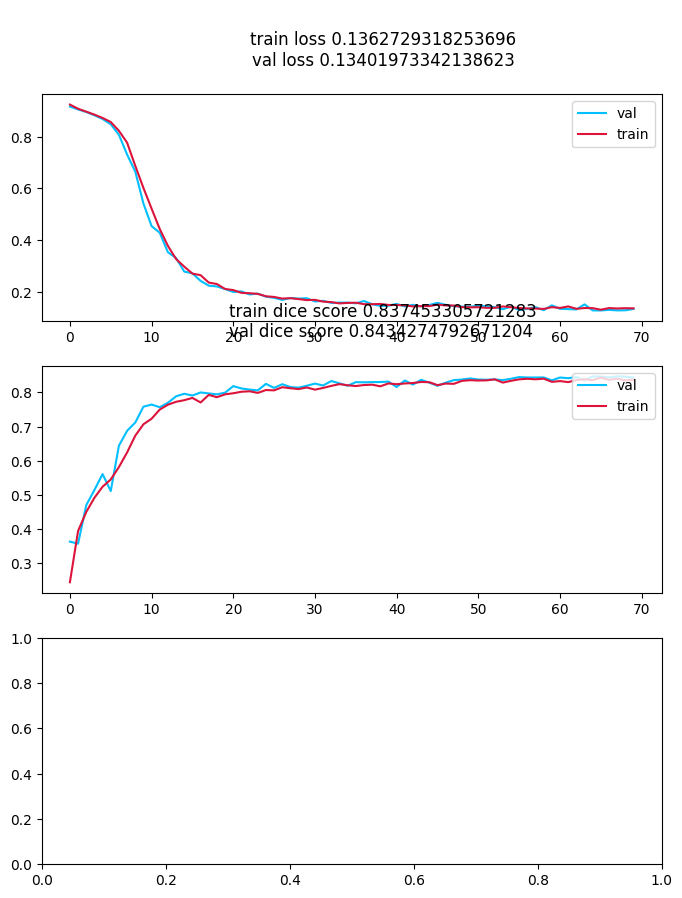

In [21]:
trainer.run()